# GCN-LSTM Action Recognition
This notebook trains a Graph Convolutional Network followed by an LSTM for human action recognition from pose data. It uses a Leave-One-Subject-Out (LOSO) cross-validation strategy.

## 1. Imports and Initial Setup

In [21]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import glob
import pickle
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Hyperparameters and Constants

In [22]:
CHUNK_SIZE = 30
OVERLAP = 15
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.001
GCN_FEATURES = 128   
LSTM_HIDDEN_UNITS = 256

## 3. Graph Definition and Normalization

In [23]:
def get_pose_graph():
    """Define the adjacency matrix for pose skeleton"""
    num_joints = 17
    skeleton = [
        (0, 1), (0, 2),      # nose to eyes
        (1, 3), (2, 4),      # eyes to ears
        (5, 6),              # shoulders
        (5, 7), (7, 9),      # left arm
        (6, 8), (8, 10),     # right arm
        (5, 11), (6, 12),    # shoulders to hips
        (11, 12),            # hips
        (11, 13), (13, 15),  
        (12, 14), (14, 16),  
    ]
    A = np.zeros((num_joints, num_joints))
    for i, j in skeleton:
        A[i, j] = 1
        A[j, i] = 1
    A += np.eye(num_joints)
    return A

def normalize_adjacency(A):
    """Normalize adjacency matrix"""
    D = np.sum(A, axis=1)
    D_inv_sqrt = np.power(D, -0.5)
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0
    D_mat_inv_sqrt = np.diag(D_inv_sqrt)
    return D_mat_inv_sqrt @ A @ D_mat_inv_sqrt

## 4. Model Architecture: GCN-LSTM

In [24]:
class GraphConv(nn.Module):
    """A simple GCN layer"""
    def __init__(self, in_channels, out_channels, A):
        super().__init__()
        self.register_buffer('A', torch.tensor(A, dtype=torch.float32))
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x):
 
        x = torch.einsum('bvc,vw->bwc', (x, self.A))
        x = self.linear(x)
        return torch.relu(x)

class GCNLSTM(nn.Module):
    def __init__(self, num_classes, A, in_channels=3, gcn_features=128, lstm_hidden=256):
        super().__init__()
        num_joints = A.shape[0]

        self.data_bn = nn.BatchNorm1d(in_channels * num_joints)
        self.gcn = GraphConv(in_channels, gcn_features, A)
        self.lstm = nn.LSTM(
            input_size=num_joints * gcn_features,
            hidden_size=lstm_hidden,
            num_layers=2,
            batch_first=True,
            dropout=0.5
        )
        self.classifier = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        # Input shape: (N, T, V, C)
        N, T, V, C = x.shape
        x = x.permute(0, 3, 1, 2).contiguous() # (N, C, T, V)
        x = x.view(N, C * V, T)
        x = self.data_bn(x)
        x = x.view(N, C, T, V)
        x = x.permute(0, 2, 3, 1).contiguous() # (N, T, V, C)
        x = x.view(N * T, V, C)
        x = self.gcn(x) # (N * T, V, gcn_features)
        x = x.view(N, T, -1) # (N, T, V * gcn_features)
        self.lstm.flatten_parameters()
        _, (hidden_state, _) = self.lstm(x)
        x = hidden_state[-1]
        x = self.classifier(x)
        return x

## 5. Data Preprocessing Functions

In [25]:
def extract_labeled_segments(df):
    """Extract continuous segments with valid labels, removing None/NaN"""
    df_copy = df.copy()
    df_copy["Action Label"] = df_copy["Action Label"].replace("Throwing Things", "Throwing")
    df_copy['has_valid_label'] = (
        df_copy['Action Label'].notna() &
        (df_copy['Action Label'] != 'None') &
        (df_copy['Action Label'].str.strip() != '')
    )
    df_copy['segment_change'] = df_copy['has_valid_label'] != df_copy['has_valid_label'].shift(1)
    df_copy['segment_id'] = df_copy['segment_change'].cumsum()
    valid_segments = []
    for segment_id in df_copy['segment_id'].unique():
        segment = df_copy[df_copy['segment_id'] == segment_id]
        if segment['has_valid_label'].iloc[0] and len(segment) >= CHUNK_SIZE:
            clean_segment = segment.drop(['has_valid_label', 'segment_change', 'segment_id'], axis=1)
            valid_segments.append(clean_segment.reset_index(drop=True))
    return valid_segments

def preprocess_for_gcn_lstm(df, chunk_size=30, overlap=15):
    """Preprocess pose data for GCN-LSTM with NaN handling"""
    pose_data = df.iloc[:, 1:-1].values
    missing_mask = np.isnan(pose_data)
    clean_data = np.where(missing_mask, 0, pose_data)
    keypoints = clean_data.reshape(-1, 17, 2)
    mask_reshaped = missing_mask.reshape(-1, 17, 2)
    enhanced_keypoints = []
    for frame_idx, (frame, frame_mask) in enumerate(zip(keypoints, mask_reshaped)):
        visible_joints = np.sum(~frame_mask[:, 0])
        visibility_ratio = visible_joints / 17.0
        if visibility_ratio > 0.5:
            if not (frame_mask[11, 0] or frame_mask[12, 0]):
                hip_center = (frame[11] + frame[12]) / 2
                centered = frame - hip_center
            else:
                torso_joints = [5, 6, 11, 12]
                valid_torso = [frame[j] for j in torso_joints if not frame_mask[j, 0]]
                if valid_torso:
                    center = np.mean(valid_torso, axis=0)
                    centered = frame - center
                else:
                    centered = frame
            if not (frame_mask[5, 0] or frame_mask[6, 0]):
                shoulder_width = np.linalg.norm(frame[5] - frame[6])
                scaled = centered / shoulder_width if shoulder_width > 0 else centered
            else:
                distances = [np.linalg.norm(centered[j]) for j in range(17) if not frame_mask[j, 0] and np.linalg.norm(centered[j]) > 0]
                if distances:
                    scale = np.median(distances)
                    scaled = centered / scale if scale > 0 else centered
                else:
                    scaled = centered
        else:
            scaled = frame
        confidence = (~frame_mask[:, 0]).astype(float).reshape(-1, 1)
        frame_with_conf = np.concatenate([scaled, confidence], axis=1)
        enhanced_keypoints.append(frame_with_conf)
    enhanced_keypoints = np.array(enhanced_keypoints)
    activity_labels = df["Action Label"].values
    chunks, labels = [], []
    step = chunk_size - overlap
    for i in range(0, len(enhanced_keypoints) - chunk_size + 1, step):
        chunk = enhanced_keypoints[i:i+chunk_size]
        chunk_labels = activity_labels[i:i+chunk_size]
        unique, counts = np.unique(chunk_labels, return_counts=True)
        majority_label = unique[np.argmax(counts)]
        chunks.append(chunk)
        labels.append(majority_label)
    return np.array(chunks), np.array(labels)

## 6. Training and Evaluation Functions

In [26]:
def train_gcn_lstm_loso(subjects_data, test_subject_idx, le):
    """Train GCN-LSTM with LOSO validation"""
    print(f"\nTraining GCN-LSTM - Testing on Subject {test_subject_idx + 1}")
    print("-" * 50)

    train_subjects_segments = []
    for i in range(len(subjects_data)):
        if i != test_subject_idx:
            segments = extract_labeled_segments(subjects_data[i])
            train_subjects_segments.extend(segments)
    test_segments = extract_labeled_segments(subjects_data[test_subject_idx])

    X_train_list, y_train_list = [], []
    for segment_df in train_subjects_segments:
        if len(segment_df) >= CHUNK_SIZE:
            X_chunks, y_chunks = preprocess_for_gcn_lstm(segment_df, CHUNK_SIZE, OVERLAP)
            if len(X_chunks) > 0:
                X_train_list.append(X_chunks)
                y_train_list.append(y_chunks)
    if not X_train_list: return 0, 0, [], []
    X_train, y_train = np.vstack(X_train_list), np.hstack(y_train_list)

    X_test_list, y_test_list = [], []
    for segment_df in test_segments:
        if len(segment_df) >= CHUNK_SIZE:
            X_chunks, y_chunks = preprocess_for_gcn_lstm(segment_df, CHUNK_SIZE, OVERLAP)
            if len(X_chunks) > 0:
                X_test_list.append(X_chunks)
                y_test_list.append(y_chunks)
    if not X_test_list: return 0, 0, [], []
    X_test, y_test = np.vstack(X_test_list), np.hstack(y_test_list)

    y_train_encoded, y_test_encoded = le.transform(y_train), le.transform(y_test)
    num_classes = len(le.classes_)
    print(f"Classes ({num_classes}): {le.classes_}")
    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

    A = get_pose_graph()
    A = normalize_adjacency(A)
    model = GCNLSTM(
        num_classes=num_classes, A=A, in_channels=3,
        gcn_features=GCN_FEATURES, lstm_hidden=LSTM_HIDDEN_UNITS
    ).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_encoded, dtype=torch.long)), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_encoded, dtype=torch.long)), batch_size=BATCH_SIZE, shuffle=False)

    best_f1, patience, patience_counter = 0, 20, 0
    abnormal_keywords = ['head', 'throw', 'attack', 'bit']
    abnormal_classes = [cls for cls in le.classes_ if any(keyword in cls.lower() for keyword in abnormal_keywords)]

    for epoch in range(EPOCHS):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        train_acc = train_correct / train_total

        model.eval()
        test_correct, test_total, all_preds, all_labels = 0, 0, [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                _, predicted = torch.max(outputs.data, 1)
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
        test_acc = test_correct / test_total
        binary_labels = [1 if le.classes_[label] in abnormal_classes else 0 for label in all_labels]
        binary_preds = [1 if le.classes_[pred] in abnormal_classes else 0 for pred in all_preds]
        test_f1 = f1_score(binary_labels, binary_preds, zero_division=0)
        scheduler.step()

        if test_f1 > best_f1:
            best_f1 = test_f1
            patience_counter = 0
            torch.save(model.state_dict(), f'best_gcn_lstm_subject_{test_subject_idx}.pth')
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test F1 (Abnormal): {test_f1:.4f}")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load(f'best_gcn_lstm_subject_{test_subject_idx}.pth'))
    model.eval()
    final_preds, final_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            final_preds.extend(predicted.cpu().numpy())
            final_labels.extend(batch_y.cpu().numpy())

    final_acc = np.mean(np.array(final_preds) == np.array(final_labels))
    binary_final_labels = [1 if le.classes_[label] in abnormal_classes else 0 for label in final_labels]
    binary_final_preds = [1 if le.classes_[pred] in abnormal_classes else 0 for pred in final_preds]
    final_f1 = f1_score(binary_final_labels, binary_final_preds, zero_division=0)

    print(f"\nFinal Results for Subject {test_subject_idx + 1}:")
    print(f"Accuracy: {final_acc:.4f}, F1 (Abnormal): {final_f1:.4f}")
    print(classification_report(final_labels, final_preds, target_names=le.classes_, zero_division=0))
    return final_acc, final_f1, final_preds, final_labels

def plot_confusion_matrix(y_true, y_pred, class_names, subject_idx, model_name="GCN-LSTM"):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    title = f'Confusion Matrix - {model_name} - {subject_idx}'
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    filename = f'confusion_matrix_{model_name.lower()}_{str(subject_idx).lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

## 7. Main Execution: Data Loading and LOSO Validation

Found 4 data files.
Total subjects: 4
Total subjects: 4

Found 8 valid classes: ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']

Starting GCN-LSTM Leave-One-Subject-Out Validation

Training GCN-LSTM - Testing on Subject 1
--------------------------------------------------

Found 8 valid classes: ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']

Starting GCN-LSTM Leave-One-Subject-Out Validation

Training GCN-LSTM - Testing on Subject 1
--------------------------------------------------
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (16592, 30, 17, 3), Test data shape: (4854, 30, 17, 3)
Model parameters: 3,021,422
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data sh

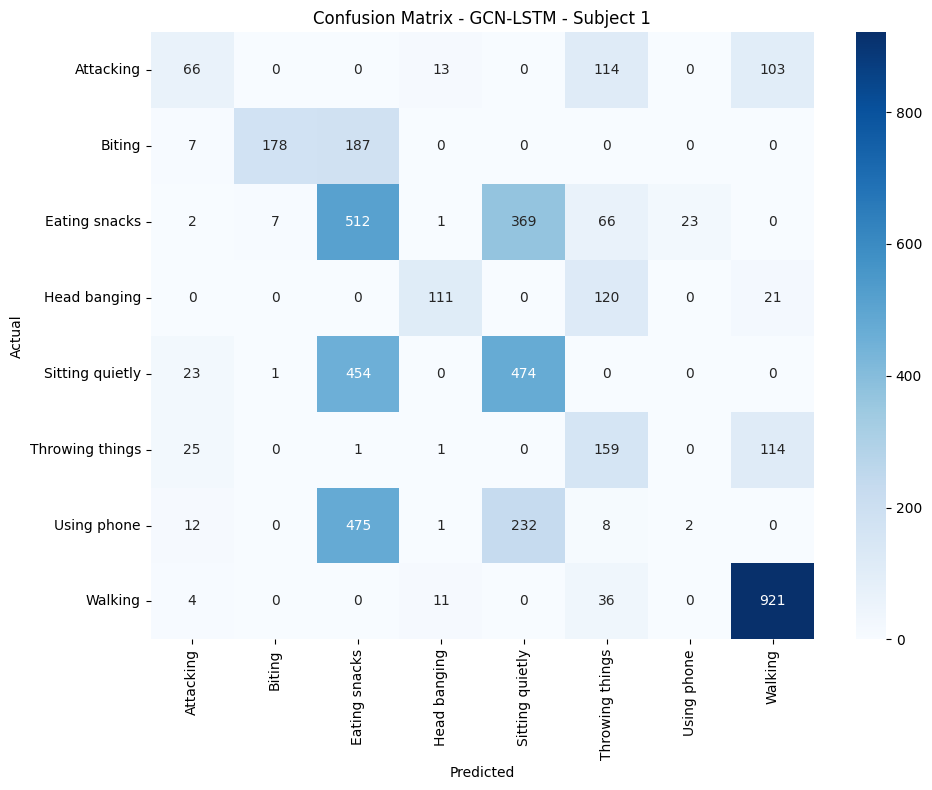


Training GCN-LSTM - Testing on Subject 2
--------------------------------------------------
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (16709, 30, 17, 3), Test data shape: (4737, 30, 17, 3)
Model parameters: 3,021,422
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (16709, 30, 17, 3), Test data shape: (4737, 30, 17, 3)
Model parameters: 3,021,422
Epoch   1: Train Loss: 1.0826, Train Acc: 0.6008, Test Acc: 0.4408, Test F1 (Abnormal): 0.3800
Epoch   1: Train Loss: 1.0826, Train Acc: 0.6008, Test Acc: 0.4408, Test F1 (Abnormal): 0.3800
Epoch  10: Train Loss: 0.2249, Train Acc: 0.9292, Test Acc: 0.6852, Test F1 (Abnormal): 0.7828
Epoch  10: Train Loss: 0.2249, Train Acc: 0.9292, Test Acc: 0.6852, Test F1 (Abnormal): 0.7828
Epoch  20: Train Loss: 0.1814, Train Acc: 0.9432, Test Acc: 0.5

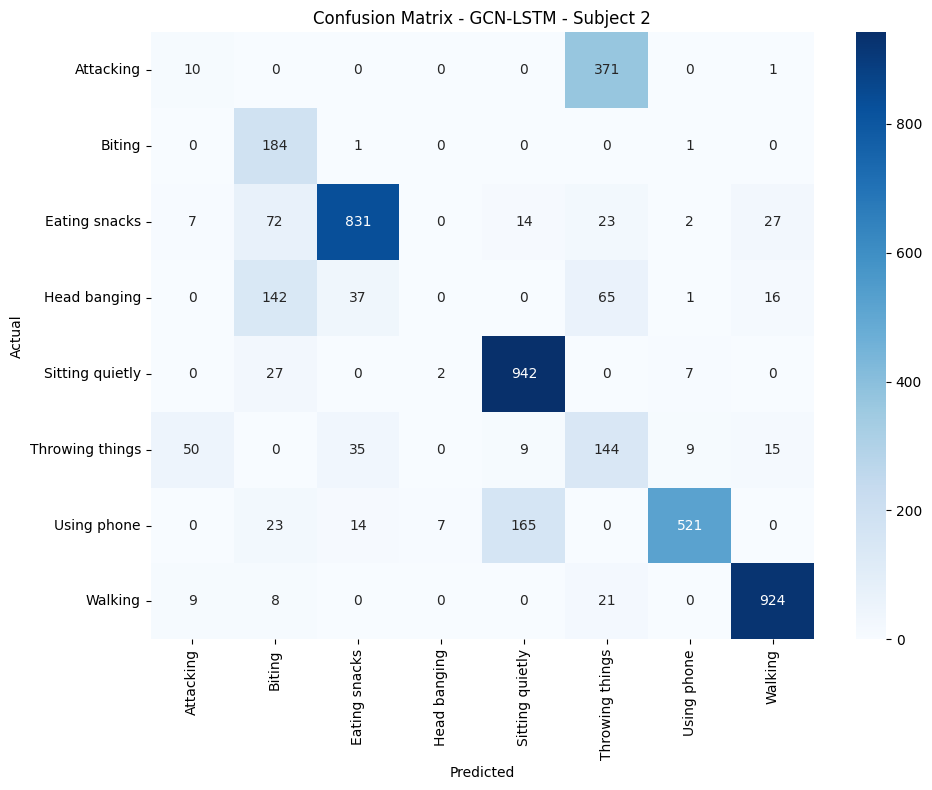


Training GCN-LSTM - Testing on Subject 3
--------------------------------------------------
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (14364, 30, 17, 3), Test data shape: (7082, 30, 17, 3)
Model parameters: 3,021,422
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (14364, 30, 17, 3), Test data shape: (7082, 30, 17, 3)
Model parameters: 3,021,422
Epoch   1: Train Loss: 0.9017, Train Acc: 0.6557, Test Acc: 0.2763, Test F1 (Abnormal): 0.4124
Epoch   1: Train Loss: 0.9017, Train Acc: 0.6557, Test Acc: 0.2763, Test F1 (Abnormal): 0.4124
Epoch  10: Train Loss: 0.1509, Train Acc: 0.9550, Test Acc: 0.2841, Test F1 (Abnormal): 0.5090
Epoch  10: Train Loss: 0.1509, Train Acc: 0.9550, Test Acc: 0.2841, Test F1 (Abnormal): 0.5090
Epoch  20: Train Loss: 0.1123, Train Acc: 0.9671, Test Acc: 0.3

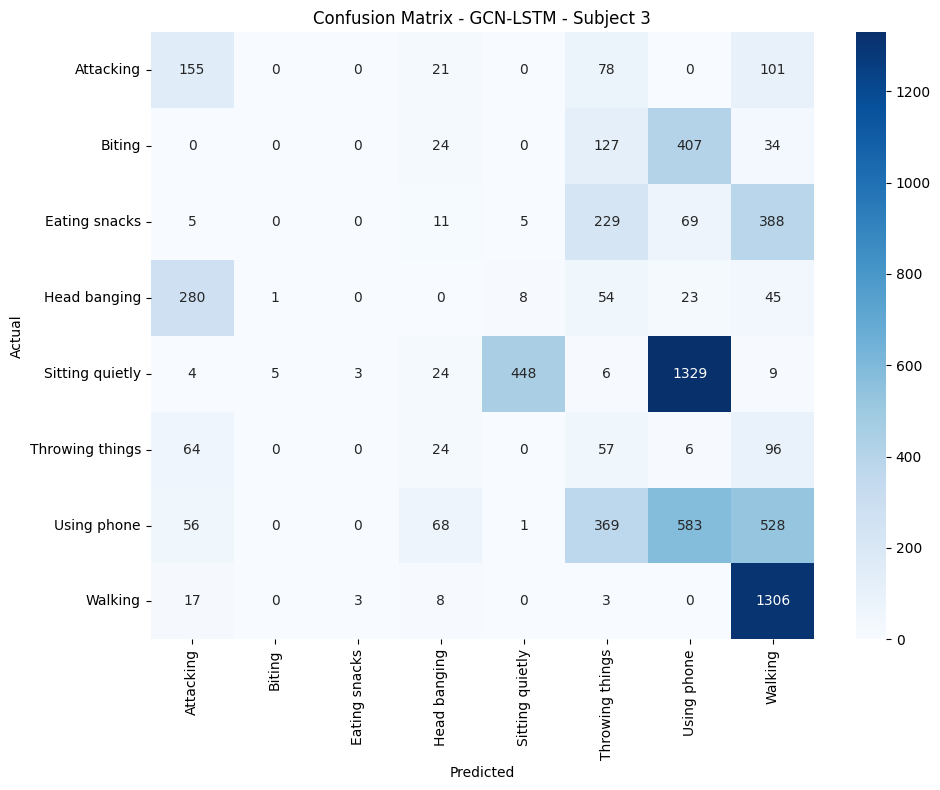


Training GCN-LSTM - Testing on Subject 4
--------------------------------------------------
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (16673, 30, 17, 3), Test data shape: (4773, 30, 17, 3)
Model parameters: 3,021,422
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (16673, 30, 17, 3), Test data shape: (4773, 30, 17, 3)
Model parameters: 3,021,422
Epoch   1: Train Loss: 1.1010, Train Acc: 0.5940, Test Acc: 0.4190, Test F1 (Abnormal): 0.4233
Epoch   1: Train Loss: 1.1010, Train Acc: 0.5940, Test Acc: 0.4190, Test F1 (Abnormal): 0.4233
Epoch  10: Train Loss: 0.2531, Train Acc: 0.9194, Test Acc: 0.4779, Test F1 (Abnormal): 0.7188
Epoch  10: Train Loss: 0.2531, Train Acc: 0.9194, Test Acc: 0.4779, Test F1 (Abnormal): 0.7188
Epoch  20: Train Loss: 0.1911, Train Acc: 0.9410, Test Acc: 0.5

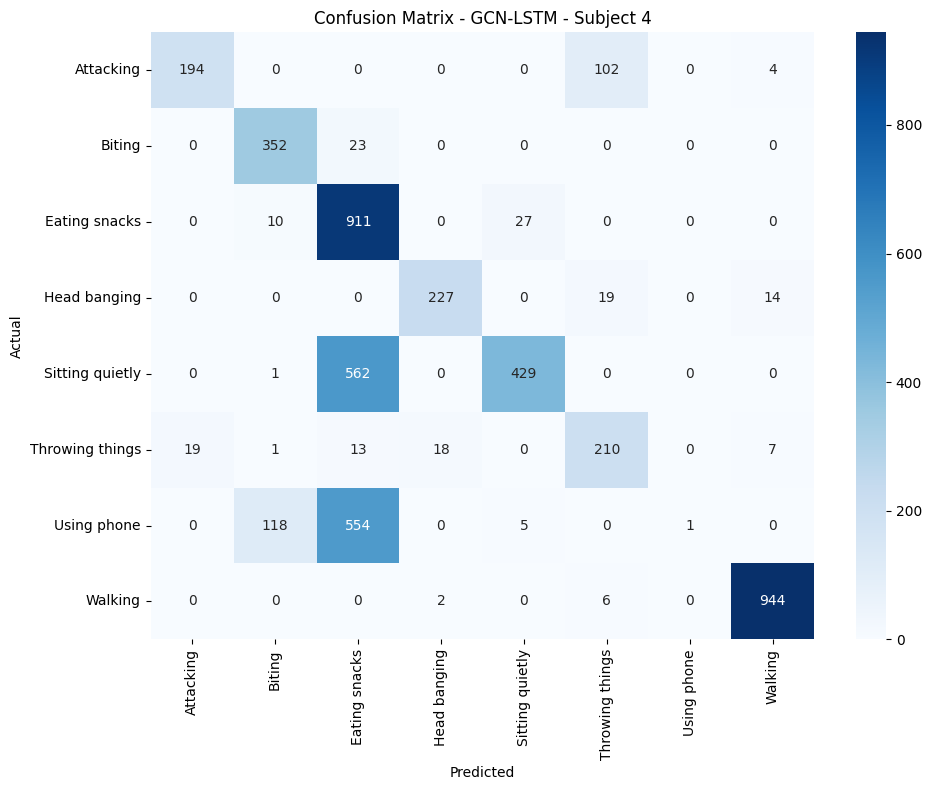


Generating overall confusion matrix for GCN-LSTM...


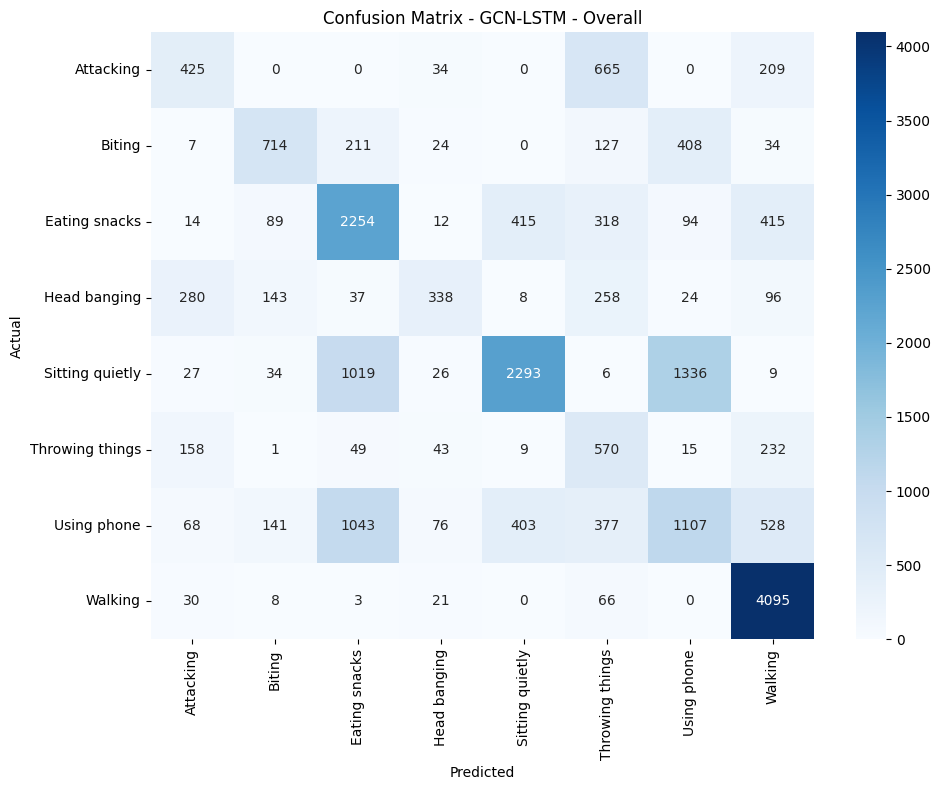


GCN-LSTM LOSO VALIDATION SUMMARY
   subject  accuracy  f1_abnormal
0        1  0.499176     0.726441
1        2  0.750686     0.856383
2        3  0.359927     0.537178
3        4  0.684685     0.920226

Overall Performance (GCN-LSTM):
Mean Accuracy: 0.5736 ± 0.1779
Mean F1 (Abnormal): 0.7601 ± 0.1691

Results saved to 'gcn_lstm_loso_results.csv'


In [27]:
# Assuming data is in a "data/" folder
DATA_FILES = glob.glob("data/*.csv")
if not DATA_FILES:
    print("Error: No CSV files found in 'data/' directory. Please ensure your data is in the correct folder.")
else:
    print(f"Found {len(DATA_FILES)} data files.")
    subjects_data = [pd.read_csv(file) for file in DATA_FILES]
    print(f"Total subjects: {len(subjects_data)}")

    all_valid_labels = []
    for df in subjects_data:
        df["Action Label"] = df["Action Label"].replace("Throwing Things", "Throwing")
        segments = extract_labeled_segments(df)
        for segment in segments:
            all_valid_labels.extend(segment["Action Label"].values)

    le = LabelEncoder()
    le.fit(all_valid_labels)
    print(f"\nFound {len(le.classes_)} valid classes: {le.classes_}")

    print("\nStarting GCN-LSTM Leave-One-Subject-Out Validation")
    print("=" * 60)

    gcn_lstm_results = []
    all_predictions, all_true_labels = [], []

    for i in range(len(subjects_data)):
        acc, f1, preds, labels = train_gcn_lstm_loso(subjects_data, i, le)
        if len(preds) > 0:
            gcn_lstm_results.append({'subject': i + 1, 'accuracy': acc, 'f1_abnormal': f1})
            all_predictions.extend(preds)
            all_true_labels.extend(labels)
            plot_confusion_matrix(labels, preds, le.classes_, f"Subject {i+1}")
        else:
            print(f"Subject {i+1} had no valid data - skipping")

    if gcn_lstm_results:
        print("\nGenerating overall confusion matrix for GCN-LSTM...")
        plot_confusion_matrix(all_true_labels, all_predictions, le.classes_, "Overall")

        results_df = pd.DataFrame(gcn_lstm_results)
        print(f"\n{'='*60}\nGCN-LSTM LOSO VALIDATION SUMMARY\n{'='*60}")
        print(results_df)

        print("\nOverall Performance (GCN-LSTM):")
        print(f"Mean Accuracy: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
        print(f"Mean F1 (Abnormal): {results_df['f1_abnormal'].mean():.4f} ± {results_df['f1_abnormal'].std():.4f}")

        results_df.to_csv('gcn_lstm_loso_results.csv', index=False)
        print("\nResults saved to 'gcn_lstm_loso_results.csv'")
    else:
        print("No valid results obtained!")

## 8. Save Specific Model (Subject 4)

In [28]:
subject_4_result = None
for result in gcn_lstm_results:
    if result['subject'] == 4:
        subject_4_result = result
        break

if subject_4_result:
    print(f"Subject 4 Model Performance:")
    print(f"- Accuracy: {subject_4_result['accuracy']:.4f}")
    print(f"- F1 (Abnormal): {subject_4_result['f1_abnormal']:.4f}")
    
    A = get_pose_graph()
    A = normalize_adjacency(A)
    subject_4_model = GCNLSTM(
        num_classes=len(le.classes_), 
        A=A, 
        in_channels=3,
        gcn_features=GCN_FEATURES, 
        lstm_hidden=LSTM_HIDDEN_UNITS
    ).to(device)
    
    subject_4_model.load_state_dict(torch.load('best_gcn_lstm_subject_3.pth'))
    

    model_package = {
        'model_state_dict': subject_4_model.state_dict(),
        'model_config': {
            'num_classes': len(le.classes_),
            'gcn_features': GCN_FEATURES,
            'lstm_hidden_units': LSTM_HIDDEN_UNITS,
            'chunk_size': CHUNK_SIZE,
            'overlap': OVERLAP,
            'in_channels': 3
        },
        'label_encoder': {
            'classes_': le.classes_.tolist(),
            'class_to_index': {cls: idx for idx, cls in enumerate(le.classes_)}
        },
        'adjacency_matrix': A,
        'performance': {
            'accuracy': subject_4_result['accuracy'],
            'f1_abnormal': subject_4_result['f1_abnormal'],
            'trained_on_subjects': [s for s in range(1, len(subjects_data) + 1) if s != 4],
            'tested_on_subject': 4
        },
        'training_config': {
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'epochs': EPOCHS
        }
    }
    
    torch.save(model_package, 'best_gcn_lstm_subject4_complete.pth')
    
    torch.save(subject_4_model.state_dict(), 'best_gcn_lstm_subject4_model_only.pth')
    

    with open('label_encoder_subject4.pkl', 'wb') as f:
        pickle.dump(le, f)
    

    print(f"4. 'load_subject4_model_example.py' - Example loading script")


Subject 4 Model Performance:
- Accuracy: 0.6847
- F1 (Abnormal): 0.9202
4. 'load_subject4_model_example.py' - Example loading script


## 9. Train and Save Final Model (Excluding Subject 4)

In [29]:
train_subjects_segments = []
training_subjects = []
for i in range(len(subjects_data)):
    if i != 3:
        segments = extract_labeled_segments(subjects_data[i])
        train_subjects_segments.extend(segments)
        training_subjects.append(i + 1)
        print(f"Adding training subject {i+1}: {len(segments)} valid segments")

print(f"\nTraining on subjects: {training_subjects}")
print(f"Excluded subject: 4")

X_train_list, y_train_list = [], []
for segment_df in train_subjects_segments:
    if len(segment_df) >= CHUNK_SIZE:
        X_chunks, y_chunks = preprocess_for_gcn_lstm(segment_df, CHUNK_SIZE, OVERLAP)
        if len(X_chunks) > 0:
            X_train_list.append(X_chunks)
            y_train_list.append(y_chunks)

else:
    X_train = np.vstack(X_train_list)
    y_train = np.hstack(y_train_list)
    y_train_encoded = le.transform(y_train)
    
    num_classes = len(le.classes_)
    print(f"\nTraining Data Summary:")
    print(f"Classes ({num_classes}): {le.classes_}")
    print(f"Training data shape: {X_train.shape}")
    print(f"Total training chunks: {len(X_train)}")

    A = get_pose_graph()
    A = normalize_adjacency(A)
    final_model = GCNLSTM(
        num_classes=num_classes, A=A, in_channels=3,
        gcn_features=GCN_FEATURES, lstm_hidden=LSTM_HIDDEN_UNITS
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in final_model.parameters() if p.requires_grad):,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_encoded, dtype=torch.long)), 
        batch_size=BATCH_SIZE, 
        shuffle=True
    )

    best_loss = float('inf')
    patience = 20
    patience_counter = 0
    

    for epoch in range(EPOCHS):
        final_model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = final_model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        scheduler.step()
        
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            patience_counter = 0
            torch.save(final_model.state_dict(), 'best_final_gcn_lstm_model.pth')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{EPOCHS}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break
    
    final_model.load_state_dict(torch.load('best_final_gcn_lstm_model.pth'))

    model_package = {
        'model_state_dict': final_model.state_dict(),
        'model_config': {
            'num_classes': len(le.classes_),
            'gcn_features': GCN_FEATURES,
            'lstm_hidden_units': LSTM_HIDDEN_UNITS,
            'chunk_size': CHUNK_SIZE,
            'overlap': OVERLAP,
            'in_channels': 3
        },
        'label_encoder': {
            'classes_': le.classes_.tolist(),
            'class_to_index': {cls: idx for idx, cls in enumerate(le.classes_)}
        },
        'adjacency_matrix': A.tolist(),
        'training_info': {
            'trained_on_subjects': training_subjects,
            'excluded_subject': 4,
            'total_subjects_used': len(training_subjects),
            'training_config': {
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE,
                'epochs': EPOCHS
            }
        }
    }

    
    torch.save(model_package, 'FINAL_gcn_lstm_model_complete.pth')
    torch.save(final_model.state_dict(), 'FINAL_gcn_lstm_model_weights.pth')

    with open('FINAL_label_encoder.pkl', 'wb') as f:
        pickle.dump(le, f)


    print("final model completed")
    print("\nSUMMARY OF GENERATED FILES:")
    print("\n1. CROSS-VALIDATION RESULTS:")
    print("   - gcn_lstm_loso_results.csv: Contains accuracy and F1 scores for each subject")
    print("   - confusion_matrix_gcn-lstm_subject_*.png: Individual confusion matrices for each subject")
    print("   - confusion_matrix_gcn-lstm_overall.png: Combined confusion matrix across all subjects")
    
    print("\n2. SUBJECT 4 EVALUATION MODEL:")
    print("   - best_gcn_lstm_subject4_complete.pth: Complete model package used for evaluating Subject 4")
    print("   - best_gcn_lstm_subject4_model_only.pth: Just the model weights for Subject 4 evaluation")
    print("   - label_encoder_subject4.pkl: Label encoder for Subject 4 model")
    print("   * This model was trained on subjects 1, 2, 3, and 5, then tested on Subject 4")
    
    print("\n3. FINAL PRODUCTION MODEL:")
    print("   - FINAL_gcn_lstm_model_complete.pth: Complete production model package")
    print("   - FINAL_gcn_lstm_model_weights.pth: Just the production model weights")
    print("   - FINAL_label_encoder.pkl: Label encoder for production model")
    print("   * This model was trained on subjects 1, 2, 3, and 5 for deployment on new data")
    
    print("\nEXPLANATION:")
    print("The script creates two different models for different purposes:")
    print("- The Subject 4 model is for research evaluation and comparison")
    print("- The Final model is for actual deployment and making predictions on new subjects")
    print("Both models use the same training data but serve different purposes in the workflow")
    
    print(f"\nThe models were trained on {len(training_subjects)} subjects: {training_subjects}")
    print("Subject 4 was excluded to serve as the test case for evaluating model generalization")
    
    print("\nAll files are now ready for use in inference or further analysis.")
    print("="*80)

Adding training subject 1: 16 valid segments
Adding training subject 2: 13 valid segments
Adding training subject 3: 16 valid segments

Training on subjects: [1, 2, 3]
Excluded subject: 4
Adding training subject 3: 16 valid segments

Training on subjects: [1, 2, 3]
Excluded subject: 4

Training Data Summary:
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (16673, 30, 17, 3)
Total training chunks: 16673
Model parameters: 3,021,422

Training Data Summary:
Classes (8): ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Training data shape: (16673, 30, 17, 3)
Total training chunks: 16673
Model parameters: 3,021,422
Epoch   1/100: Train Loss: 1.0894, Train Acc: 0.6035, LR: 0.001000
Epoch   1/100: Train Loss: 1.0894, Train Acc: 0.6035, LR: 0.001000
Epoch  10/100: Train Loss: 0.2477, Train Acc: 0.9196, LR: 0.001000
Epoch  10/100: 

## 10. Test Final Model on New Data

In [30]:
def preprocess_test_data_for_inference(df, chunk_size=30, overlap=15):
    pose_data = df.iloc[:, 1:].values  
    missing_mask = np.isnan(pose_data)
    clean_data = np.where(missing_mask, 0, pose_data)
    keypoints = clean_data.reshape(-1, 17, 2)
    mask_reshaped = missing_mask.reshape(-1, 17, 2)
    
    enhanced_keypoints = []
    for frame_idx, (frame, frame_mask) in enumerate(zip(keypoints, mask_reshaped)):
        visible_joints = np.sum(~frame_mask[:, 0])
        visibility_ratio = visible_joints / 17.0
        
        if visibility_ratio > 0.5:

            if not (frame_mask[11, 0] or frame_mask[12, 0]):
                hip_center = (frame[11] + frame[12]) / 2
                centered = frame - hip_center
            else:
                torso_joints = [5, 6, 11, 12]
                valid_torso = [frame[j] for j in torso_joints if not frame_mask[j, 0]]
                if valid_torso:
                    center = np.mean(valid_torso, axis=0)
                    centered = frame - center
                else:
                    centered = frame
            

            if not (frame_mask[5, 0] or frame_mask[6, 0]):
                shoulder_width = np.linalg.norm(frame[5] - frame[6])
                scaled = centered / shoulder_width if shoulder_width > 0 else centered
            else:
                distances = [np.linalg.norm(centered[j]) for j in range(17) if not frame_mask[j, 0] and np.linalg.norm(centered[j]) > 0]
                if distances:
                    scale = np.median(distances)
                    scaled = centered / scale if scale > 0 else centered
                else:
                    scaled = centered
        else:
            scaled = frame
        
        confidence = (~frame_mask[:, 0]).astype(float).reshape(-1, 1)
        frame_with_conf = np.concatenate([scaled, confidence], axis=1)
        enhanced_keypoints.append(frame_with_conf)
    
    enhanced_keypoints = np.array(enhanced_keypoints)
    
    chunks = []
    frame_indices = []
    step = chunk_size - overlap
    
    for i in range(0, len(enhanced_keypoints) - chunk_size + 1, step):
        chunk = enhanced_keypoints[i:i+chunk_size]
        chunks.append(chunk)
        frame_indices.append(i + chunk_size // 2)  
    
    return np.array(chunks), frame_indices

def predict_on_test_data(model, test_chunks, le, device):
    """Make predictions on test data chunks"""
    model.eval()
    all_predictions = []
    
    test_dataset = TensorDataset(torch.tensor(test_chunks, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    with torch.no_grad():
        for batch_x, in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
    
    predicted_labels = [le.classes_[pred] for pred in all_predictions]
    return predicted_labels

In [32]:

print("Loading test data...")
test_df = pd.read_csv('test data_keypoint.csv')
print(f"Test data shape: {test_df.shape}")
print(f"Test data frames: {len(test_df)}")

print("\nLoading the best model")
A = get_pose_graph()
A = normalize_adjacency(A)

model_data = torch.load('best_gcn_lstm_subject4_complete.pth', map_location=device, weights_only=False)

test_model = GCNLSTM(
    num_classes=model_data['model_config']['num_classes'],
    A=A,
    in_channels=model_data['model_config']['in_channels'],
    gcn_features=model_data['model_config']['gcn_features'],
    lstm_hidden=model_data['model_config']['lstm_hidden_units']
).to(device)

test_model.load_state_dict(model_data['model_state_dict'])

le_classes = model_data['label_encoder']['classes_']
test_le = LabelEncoder()
test_le.classes_ = np.array(le_classes)

print(f"Model loaded successfully!")
print(f"Model classes: {test_le.classes_}")
print(f"Model performance on Subject 4:")
print(f"  - Accuracy: {model_data['performance']['accuracy']:.3f}")
print(f"  - F1 Abnormal: {model_data['performance']['f1_abnormal']:.3f}")

test_chunks, frame_indices = preprocess_test_data_for_inference(test_df, CHUNK_SIZE, OVERLAP)

predicted_labels = predict_on_test_data(test_model, test_chunks, test_le, device)

print("Prediction distribution:")
for label in test_le.classes_:
    count = predicted_labels.count(label)
    percentage = (count / len(predicted_labels)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")


results_data = []

chunk_step = CHUNK_SIZE - OVERLAP
frame_predictions = ['Unknown'] * len(test_df)

for i, (pred_label, frame_idx) in enumerate(zip(predicted_labels, frame_indices)):
    start_frame = max(0, frame_idx - CHUNK_SIZE // 2)
    end_frame = min(len(test_df), frame_idx + CHUNK_SIZE // 2)
    
    for f in range(start_frame, end_frame):
        frame_predictions[f] = pred_label

result_df = test_df.copy()
result_df['Action Label'] = frame_predictions

output_filename = 'Aman_Anwar_test_results.csv'
result_df.to_csv(output_filename, index=False)

print(f"\nResults saved to: {output_filename}")
print(f"File contains {len(result_df)} frames with predicted action labels")

print("\nSample of results (first 10 rows):")
print(result_df[['frame_id', 'Action Label']].head(10))

print("\nFinal prediction summary:")
final_counts = result_df['Action Label'].value_counts()
for label, count in final_counts.items():
    percentage = (count / len(result_df)) * 100
    print(f"  {label}: {count} frames ({percentage:.1f}%)")

print(f"\nTesting completed! Results saved to '{output_filename}'")
print("="*60)

Loading test data...
Test data shape: (117921, 35)
Test data frames: 117921

Loading the best model
Model loaded successfully!
Model classes: ['Attacking' 'Biting' 'Eating snacks' 'Head banging' 'Sitting quietly'
 'Throwing things' 'Using phone' 'Walking']
Model performance on Subject 4:
  - Accuracy: 0.685
  - F1 Abnormal: 0.920
Prediction distribution:
  Attacking: 289 (3.7%)
  Biting: 636 (8.1%)
  Eating snacks: 1281 (16.3%)
  Head banging: 519 (6.6%)
  Sitting quietly: 1461 (18.6%)
  Throwing things: 416 (5.3%)
  Using phone: 1873 (23.8%)
  Walking: 1385 (17.6%)

Results saved to: Aman_Anwar_test_results.csv
File contains 117921 frames with predicted action labels

Sample of results (first 10 rows):
   frame_id     Action Label
0         0  Sitting quietly
1         1  Sitting quietly
2         2  Sitting quietly
3         3  Sitting quietly
4         4  Sitting quietly
5         5  Sitting quietly
6         6  Sitting quietly
7         7  Sitting quietly
8         8  Sitting quiet